# What's this code about
This file was used to calculate the adsorption rate of TMAPS onto DNA origami
Use this calculation on the simulation with blockages at the end of DNA origami.

## comments 
The code is pretty dirty now

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget 
#use this magic command in a jupyter notebook but not in a colab

In [2]:
def PairwiseDistance_Calc(traj_data_t,box):
  '''
  Compute the pairwise distance betwe
  diagnoal entries are replaced with large number because it is stupid to count yourself
  '''
  bond_vec = traj_data_t[:, None, :] - traj_data_t[None, :, :] #compute bond vector. The shape like [N,N,2]
  bond_vec =  bond_vec - np.rint(bond_vec/box[0])*box[0]
  dist_matrix = np.sqrt(np.sum(bond_vec**2,axis=-1))
  np.fill_diagonal(dist_matrix, 1000000) #so that you don't count yourself
  return dist_matrix#, debug, bond_vec

def Neighbor_List_calculator(traj_data,box, mol_2D, R_cutoff):
  '''
  input trajectories, box size, cutoff. For each frame, find the center position of 6HB (in this case, I know the index) and compute the local density.
  Remember to drop the z coordinate before input this
  mol_2D contains the list of chains on the 2D (identified by mol)
  r shape should be [timeframe, atoms, coordinate]
  output shape should be [timeframe, molecules, vector]
  '''
  neighbor_tensor = []

  for t in range(traj_data.shape[0]):
    traj_t = traj_data[t]
    sort_data = traj_t[np.lexsort(np.transpose(traj_t)[::-1])] #sort the data according to their mol_iD, then their atom id
    med_list = []                                         #Empty list to contain the position of the center of molecule

    dist_matrix = PairwiseDistance_Calc(np.array(med_list),box) #distance matrix representing the distance between chains
    neighbor_list = []
    for idx in range(dist_matrix.shape[0]):                       #it's a symmetric matrix
      #neighbor = mol_2D[np.where((dist_matrix[idx]<R_cutoff) & (dist_matrix[idx]>0.))[0]] # <R_cutoff to see if it is your neighbor, >0 to avoid counting yourself (self-distance is zero)
      neighbor = mol_2D[np.where((dist_matrix[idx]<R_cutoff))[0]] #Include yourself in the neighbor list [0] is because the output is a tuple like this (array_we_want,), so use [0] to select array_we_want
      neighbor_list.append(neighbor)
    neighbor_tensor.append(neighbor_list)
  return np.array(neighbor_tensor)                                #, dist_matrix,debug,np.array(med_list),center_position,med_id, target,bond

def Compute_position_range(backbone_traj_data_t,buffer=5):
    '''
    input the traj of 6HB backbone at each frame, find the max of x y z and add a buffer
    use this function to select the solvents (or ion TMAPS) to compute number of neighbors
    right now 6HB did not cross the boundary
    but if it does then this needs modification
    '''
    x_max = np.max(backbone_traj_data_t[:,3]) + buffer
    x_min = np.min(backbone_traj_data_t[:,3]) - buffer
    y_max = np.max(backbone_traj_data_t[:,4]) + buffer
    y_min = np.min(backbone_traj_data_t[:,4]) - buffer
    z_max = np.max(backbone_traj_data_t[:,5]) + buffer
    z_min = np.min(backbone_traj_data_t[:,5]) - buffer
    return [x_max,x_min,y_max,y_min,z_max,z_min]

def check_id_range(x):
    '''
    check if the input x (id) is in the head/Tail area (True) or in the middle region (False)
    '''
    #using scripts without block 
    #ranges = [(1, 2409), (14105, 16513), (16599, 19007), (30703, 33111), (33197, 35605),
    #          (47301, 49709), (49795, 52203), (63899, 66307), (66393, 68801), (80497, 82905),
    #          (82991, 85399), (97095, 99503)]
    ranges = [(3, 2411), (14107, 16515), (16601, 19009), (30705, 33113), (33199, 35607), (47303, 49711), (49797, 52205), (63901, 66309), (66395, 68803), (80499, 82907), (82993, 85401), (97097, 99505)]
    for range_start, range_end in ranges:
        if range_start <= x <= range_end:
            return True

    return False

def Neighbor_Selection_Distance_based(traj_data,box, R_cutoff=2):
    '''
    Compute the range of x y z of 6HB in a frame, select only the solvent in the region to compute the neighnor list
    Compute the range of 
    '''
    brush_region_neighbor_list=[]
    barebone_region_neighbor_list=[]

    solvent_data = traj_data[traj_data[:,:,2]==4]
    solvent_data = solvent_data.reshape((len(traj_data),int(len(solvent_data)/len(traj_data)),6)) # I hate this but for some reason I couldn't get the shape right
    backbone_data = traj_data[np.where(traj_data[:,:,2]==3)]
    backbone_data = backbone_data.reshape((len(traj_data),int(len(backbone_data)/len(traj_data)),6))
    for t in range(traj_data.shape[0]):
        position_range = Compute_position_range(backbone_data[t]) #compute the x y z range of the backbone
        solvent_data_t = solvent_data[t]
        filtered_solvent_data_t = solvent_data_t[np.where((solvent_data_t[:,3]<=position_range[0])&(solvent_data_t[:,3]>=position_range[1])&(solvent_data_t[:,4]<=position_range[2])&(solvent_data_t[:,4]>=position_range[3])&(solvent_data_t[:,5]<=position_range[4])&(solvent_data_t[:,5]>=position_range[5]))]
        combined_data_t = np.concatenate((filtered_solvent_data_t,backbone_data[t]),axis=0)
        dist_matrix = PairwiseDistance_Calc(combined_data_t[:,3:],box) #distance matrix, remove  mol id type

        neighbor_list = []
        brush_region_neighbor_count=0
        barebone_region_neighbor_count=0
        for idx in range(len(filtered_solvent_data_t)): #selection "based on" solvent entries
            neighbors = combined_data_t[np.where(dist_matrix[idx]<R_cutoff)] #particle that is solvent's neighbor
            for neighbor in neighbors:
                if neighbor[2]==3:#if it's a backbone. This is like a dummy check
                    neighbor_list.append(combined_data_t[idx][1]) #append its id

                    #Heads/Tail and middle
                    if check_id_range(neighbor[1]):
                        brush_region_neighbor_count+=1
                        break

                    else:
                        barebone_region_neighbor_count+=1
                        break

                    #break
                    #done
                else:
                    pass
        brush_region_neighbor_list.append(brush_region_neighbor_count)
        barebone_region_neighbor_list.append(barebone_region_neighbor_count)
    return brush_region_neighbor_list,barebone_region_neighbor_list
        #compute distance between each backbone bead and the solvent
        # if it is smaller than cutoff (=4), then counted it as being adsorbed
def Find_neighbor(solvent_data_t, position_range_for_Particle):
    filtered_solvent_data_t = solvent_data_t[np.where((solvent_data_t[:,3]<=position_range_for_Particle[0])\
                                                          &(solvent_data_t[:,3]>=position_range_for_Particle[1])\
                                                          &(solvent_data_t[:,4]<=position_range_for_Particle[2])\
                                                          &(solvent_data_t[:,4]>=position_range_for_Particle[3])\
                                                          &(solvent_data_t[:,5]<=position_range_for_Particle[4])\
                                                          &(solvent_data_t[:,5]>=position_range_for_Particle[5]))]
    return filtered_solvent_data_t
    
def remove_matching_elements(a, b):
    '''
    iterates through the elements of list 'b' and removes any matching elements from list 'a'.
    '''
    a_copy = a.copy()
    for item in b:
        if item in a_copy:
            a_copy.remove(item)
    return a_copy

def Residence_time_calculation(traj_data,box, R_cutoff=2):
    '''
    Compute the range of x y z of 6HB and brushes in a frame, select only the solvent in the region to compute the neighnor list
    The following dirty codes do:
    1. find the TMAPS (solvent) neighboring with brushes
    2. 
    
    This neglects
    1. efficiency (dirty O(N^2))
    2. calculating the residence time of TMAPS on the barebone
    '''
    neighbor_tensor = []

    solvent_data = traj_data[traj_data[:,:,2]==4]
    solvent_data = solvent_data.reshape((len(traj_data),int(len(solvent_data)/len(traj_data)),6)) # I hate this but for some reason I couldn't get the shape right
    backbone_data = traj_data[np.where(traj_data[:,:,2]==3)]
    backbone_data = backbone_data.reshape((len(traj_data),int(len(backbone_data)/len(traj_data)),6))
    brush_data = traj_data[np.where(traj_data[:,:,2]==6)]
    brush_data = brush_data.reshape((len(traj_data),int(len(brush_data)/len(traj_data)),6))
    
    for t in range(traj_data.shape[0]):
        position_range = Compute_position_range(backbone_data[t]) #compute the x y z range of the backbone
        position_range_for_brush = Compute_position_range(brush_data[t])
        solvent_data_t = solvent_data[t]
        
        #Select TMAPS prior to doing actual distance calculations 
        Near_brush_solvent_data_t = Find_neighbor(solvent_data_t, position_range_for_brush)
        Near_backbone_solvent_data_t = Find_neighbor(solvent_data_t, position_range)
        
        combined_data_t_barebone = np.concatenate((Near_backbone_solvent_data_t,backbone_data[t]),axis=0)
        combined_data_t_brush = np.concatenate((Near_brush_solvent_data_t,brush_data[t]),axis=0)
        #Compute distance matrix. IF distance is smaller than cutoff, the stuff is a neighbor
        dist_matrix_barebone = PairwiseDistance_Calc(combined_data_t_barebone[:,3:],box) #distance matrix, remove  mol id type
        dist_matrix_brush = PairwiseDistance_Calc(combined_data_t_brush[:,3:],box)
        
        
        brush_neighbor_list = []
        barebone_neighbor_list = []
        
        ##Find neighbor for barebone
        ##this will go through all solvent. for a solvent, if they are neighbor to backbone, for instance,
        ##then we add this solvent's id to a neighborlist
        for idx in range(len(Near_backbone_solvent_data_t)): #selection "based on" solvent entries
            barebone_neighbors = combined_data_t_barebone[np.where(dist_matrix_barebone[idx]<R_cutoff)] #particle that is solvent's neighbor
            #print(barebone_neighbors)
            for neighbor in barebone_neighbors:
                if neighbor[2]==3:#if it's a 6HB. This is like a dummy check
                    barebone_neighbor_list.append(combined_data_t_barebone[idx][1]) #append its id
                    break
                else:
            
                    pass
        ##Find neighbor for brush
        
        for idx in range(len(Near_brush_solvent_data_t)): #selection "based on" solvent entries
            brush_neighbors = combined_data_t_brush[np.where(dist_matrix_brush[idx]<R_cutoff)] #particle that is solvent's neighbor
            #print(brush_neighbors[:,:,1])
            for neighbor in brush_neighbors:
                print(neighbor)
                if neighbor[2]==6:#if it's a brush. This is like a dummy check
                    brush_neighbor_list.append(combined_data_t_brush[idx][1]) #append its id
                    break
                else:
                    pass
                
        # If it is barebone's neighbor, kick it out
        print(brush_neighbor_list)
        cleaned_brush_neighbor_list = remove_matching_elements(brush_neighbor_list,barebone_neighbor_list)
        neighbor_tensor.append(np.array(cleaned_brush_neighbor_list))
        #brush_region_neighbor_list.append(brush_region_neighbor_count)
        #barebone_region_neighbor_list.append(barebone_region_neighbor_count)
        #neighbor_tensor.append(np.array(neighbor_list))

    return np.array(neighbor_tensor)
    #return brush_region_neighbor_list,barebone_region_neighbor_list
    
def Compute_position_range_single_particle(traj_data,buffer=5):
    '''
    input the position of a point, output the neighboring range. lammps format [mol,id, type, x, y,z]
    '''
    x_max = np.max(traj_data[3]) + buffer
    x_min = np.min(traj_data[3]) - buffer
    y_max = np.max(traj_data[4]) + buffer
    y_min = np.min(traj_data[4]) - buffer
    z_max = np.max(traj_data[5]) + buffer
    z_min = np.min(traj_data[5]) - buffer
    return [x_max,x_min,y_max,y_min,z_max,z_min]
def Query_solvent_neighbor(traj_data,box, R_cutoff=2):
    '''
    Compute the range of x y z of 6HB and brushes in a frame, select only the solvent in the region to compute the neighnor list
    The following dirty codes do:
    1. find the TMAPS (solvent) neighboring with brushes
    2. 
    
    This neglects
    1. efficiency (dirty O(N^2))
    2. calculating the residence time of TMAPS on the barebone
    '''
    neighbor_tensor = []
    for t in range(traj_data.shape[0]): 
        neighbor_list = []
        solvent_idx = np.where(traj_data[t][:,2]==4)[0] #add [0] because the return is like [array(sdfsf),]
        for idx in solvent_idx: #selection "based on" solvent entries
            position_range = Compute_position_range_single_particle(traj_data[t,idx,:])
            all_data_except_self = np.delete(traj_data[t],idx,axis=0)
            nearby_particle = Find_neighbor(all_data_except_self, position_range)
            
            if len(nearby_particle)==0:
                pass
            else:
                #print(nearby_particle)
                single_particle_data = [traj_data[t,idx,:]]
                combined_data_t = np.concatenate((single_particle_data,nearby_particle),axis=0)
                dist_matrix = PairwiseDistance_Calc(combined_data_t[:,3:],box)
                
                #compute the pairwise distance with these particles
                a_solvent_neighbors = combined_data_t[np.where(dist_matrix[0]<R_cutoff)]
                if len(a_solvent_neighbors)==0: #if all pre-selected neighbors are not actually within cutoff
                    pass
                else:
                #print(a_solvent_neighbors)
                    for neighbor in a_solvent_neighbors:
                        if neighbor[2]==3:#if it's a backbone's neighbor, we don't want it at all 
                            break
                        elif neighbor[2]==6: #if it's a brush neighbor, we want it
                            atom_id = traj_data[t,idx,1]
                            neighbor_list.append(atom_id)
                        else: #it's not a neighbor of brush or backbone, we don't want it 
                            pass
        neighbor_list = np.unique(neighbor_list)#remove duplicates
        neighbor_tensor.append(np.array(neighbor_list))
    return np.array(neighbor_tensor)
def calculate_mean_residence_time(id_list,time_series):    
    duration_list =[]
    for id in id_list:
        duration=0
        for time,id_record in enumerate(time_series):
            if id in id_record:
                duration+=1
                #if time +1 ==len(time_series): #maybe not #NO, Ishould add edge case#probably it's better to discount the edge case

                #    duration_list.append(duration)#edge case
            else: #id diappear
                duration_list.append(duration)
                duration=0
    cleaned_duration_list = list(filter(lambda num: num != 0, duration_list))      #remove zero duration
    #print(cleaned_duration_list)
    #return cleaned_duration_list
    return sum(cleaned_duration_list)/len(cleaned_duration_list)
def Residence_time_analysis(neighbor_tensor):
    '''
    Given the neighboring sovlent id (to brushes), calculate the mean residence time by
    finding the occurence length of an id. For instance [[a,b,c],[a,b],[b]], 
    the id a's residence time is 2, and b is 3, and c is 1
    '''
    ID_list = np.unique(np.concatenate(neighbor_tensor))
    residence_time = calculate_mean_residence_time(ID_list,neighbor_tensor)
    return residence_time
def Process_data(file_pos):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # We read the number of particles, the system box, and the
        # particle positions into 3 separate arrays.
        N = int(np.genfromtxt(file_pos, skip_header=3, max_rows=1))
        box_data = np.genfromtxt(file_pos, skip_header=5, max_rows=3)
        data = np.genfromtxt(file_pos, skip_header=9, invalid_raise=False)
    # Remove the unwanted text rows
    data = data[~np.isnan(data).all(axis=1)].reshape(-1, N, 6)
    box_xy = box_data[:,1]-box_data[:, 0]
    return data,box_xy

#Toy Example
#file = '/home/popo/Code file/Condensation_analysis/sweep/round5/low_conc/1invdebye/2TMAPS/product.lammpstrj'
#data,box_xy = Process_data(file)
#test = Query_solvent_neighbor(data,box_xy)


In [170]:
def calculate_mean_residence_time(id_list,time_series):    
    duration_list =[]
    for id in id_list:
        duration=0
        for t in time_series:
            if id in t:
                duration+=1
                #if t==len(time_series): #probably it's better to discount the edge case
                    #duration_list.append(duration)#edge case
            else: #id diappear
                duration_list.append(duration)
                duration=0
    cleaned_duration_list = list(filter(lambda num: num != 0, duration_list))      #remove zero duration
    #print(cleaned_duration_list)
    return sum(cleaned_duration_list)/len(cleaned_duration_list)
    
#toy_example
id_list = [1,2,3,5]
test = [[1,2],[1,2],[2,5],[1],[1,2],[2]] #duration 2, 3, 1, but the last 1 is an edge case so we delete it
calculate_mean_residence_time(id_list,test)

2.0

# Plot ssDNA and hairpin data together

In [5]:

for i in [111,222,333]:
    #file = 'Final_test/ssDNA/{}/product.lammpstrj'.format(i)
    file = 'ssDNA/product_{}.lammpstrj'.format(i)
    data,box_xy = Process_data(file)
   # brush,middle = Neighbor_Selection_Distance_based(data,box_xy)
    Neighbor_tensor = Query_solvent_neighbor(data,box_xy)
    ID_list = np.unique(np.concatenate(Neighbor_tensor))
    MRT = calculate_mean_residence_time(ID_list,Neighbor_tensor)
  #  brush_to_save = brush#[:31]
  #  middle_to_save = middle#[:31]
  #  df = pd.DataFrame({'Brush-grafted':brush_to_save, 'Bare':middle_to_save})
  #  df.to_csv('sssurface_density_{}.csv'.format(i), index=False)
    np.save('ssDNA_mean_residence_time_{}'.format(i),MRT)
    
    file = 'hairpin/product_{}.lammpstrj'.format(i)
    data,box_xy = Process_data(file)
  #  brush,middle = Neighbor_Selection_Distance_based(data,box_xy)
  #  brush_to_save = brush#[:31]
  #  middle_to_save = middle#[:31]
    Neighbor_tensor = Query_solvent_neighbor(data,box_xy)
    ID_list = np.unique(np.concatenate(Neighbor_tensor))
    MRT = calculate_mean_residence_time(ID_list,Neighbor_tensor)
 #   df = pd.DataFrame({'Brush-grafted':brush_to_save, 'Bare':middle_to_save})
  #  df.to_csv('surface_density_{}.csv'.format(i), index=False)
    np.save('dsDNA_mean_residence_time_{}'.format(i),MRT)

/tmp/ipykernel_12183/3340885213.py:288: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(neighbor_tensor)
/tmp/ipykernel_12183/3340885213.py:288: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(neighbor_tensor)
/tmp/ipykernel_12183/3340885213.py:288: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.

In [3]:

def divide_by_length(row):
    if row['Region'] == 'Brush-grafted': #'dsDNA: Brush-grafted Region':
        return row['Value'] / (56)
    #elif row['Type'] == 'ssDNA: Brush-grafted Region':
    #    return row['Value'] / (56)
    else:
        return row['Value']/((193-56))

#csv_files = ['sssurface_density_1.csv', 'sssurface_density_2.csv', 'sssurface_density_3.csv']
csv_files = ['sssurface_density_111.csv', 'sssurface_density_222.csv', 'sssurface_density_333.csv',\
            'surface_density_111.csv', 'surface_density_222.csv', 'surface_density_333.csv']

# Load and process the data from each CSV file
data_frames = []
for index,file_name in enumerate(csv_files):
    df = pd.read_csv(file_name)
    melted_df = df.melt(var_name='Region', value_name='Value')
    melted_df['Source'] = 'Sample {}'.format(file_name[-5]) #so would be Sample 1 Sample 2
    if file_name[0:2]=='ss':
        melted_df['Type'] = '6HB-5*/17/5*'
    else:
        melted_df['Type'] = '6HB-5*/17/5*-DS'
    #melted_df['Source'] = 'File {}'.format(index) # so that sns will avereage based on this column
    melted_df['Timestep'] = melted_df.groupby('Region').cumcount()*50000*0.002 #Assign time points
    # Apply the custom function to create a new column 'Result'
    melted_df['Value'] = melted_df.apply(divide_by_length, axis=1)
    data_frames.append(melted_df)

concatenated_df = pd.concat(data_frames, ignore_index=True)

print(concatenated_df)

             Region     Value    Source             Type  Timestep
0     Brush-grafted  0.035714  Sample 1     6HB-5*/17/5*       0.0
1     Brush-grafted  0.089286  Sample 1     6HB-5*/17/5*     100.0
2     Brush-grafted  0.071429  Sample 1     6HB-5*/17/5*     200.0
3     Brush-grafted  0.107143  Sample 1     6HB-5*/17/5*     300.0
4     Brush-grafted  0.107143  Sample 1     6HB-5*/17/5*     400.0
...             ...       ...       ...              ...       ...
6619           Bare  6.386861  Sample 3  6HB-5*/17/5*-DS   54700.0
6620           Bare  6.481752  Sample 3  6HB-5*/17/5*-DS   54800.0
6621           Bare  6.401460  Sample 3  6HB-5*/17/5*-DS   54900.0
6622           Bare  6.416058  Sample 3  6HB-5*/17/5*-DS   55000.0
6623           Bare  6.459854  Sample 3  6HB-5*/17/5*-DS   55100.0

[6624 rows x 5 columns]


In [4]:
#Subsample/slice the dataframe to plot less data
timestep_to_plot = list(range(100,55100,2000))
#print(timestep_to_plot)
df_sliced =  concatenated_df[concatenated_df['Timestep'].isin(timestep_to_plot)]
print(df_sliced)

             Region     Value    Source             Type  Timestep
1     Brush-grafted  0.089286  Sample 1     6HB-5*/17/5*     100.0
21    Brush-grafted  0.589286  Sample 1     6HB-5*/17/5*    2100.0
41    Brush-grafted  0.928571  Sample 1     6HB-5*/17/5*    4100.0
61    Brush-grafted  1.250000  Sample 1     6HB-5*/17/5*    6100.0
81    Brush-grafted  1.696429  Sample 1     6HB-5*/17/5*    8100.0
...             ...       ...       ...              ...       ...
6533           Bare  6.182482  Sample 3  6HB-5*/17/5*-DS   46100.0
6553           Bare  6.109489  Sample 3  6HB-5*/17/5*-DS   48100.0
6573           Bare  6.437956  Sample 3  6HB-5*/17/5*-DS   50100.0
6593           Bare  6.328467  Sample 3  6HB-5*/17/5*-DS   52100.0
6613           Bare  6.379562  Sample 3  6HB-5*/17/5*-DS   54100.0

[336 rows x 5 columns]


In [5]:
# Merge Region and type according to Dr. Arya's request
df_sliced["Name"] =  df_sliced['Type']+ ' ' + '(' + df_sliced["Region"] +')'
df_sliced.head()

/tmp/ipykernel_190/3805625906.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sliced["Name"] =  df_sliced['Type']+ ' ' + '(' + df_sliced["Region"] +')'


,Region,Value,Source,Type,Timestep,Name
1,Brush-grafted,0.089286,Sample 1,6HB-5*/17/5*,100.0,6HB-5*/17/5* (Brush-grafted)
21,Brush-grafted,0.589286,Sample 1,6HB-5*/17/5*,2100.0,6HB-5*/17/5* (Brush-grafted)
41,Brush-grafted,0.928571,Sample 1,6HB-5*/17/5*,4100.0,6HB-5*/17/5* (Brush-grafted)
61,Brush-grafted,1.250000,Sample 1,6HB-5*/17/5*,6100.0,6HB-5*/17/5* (Brush-grafted)
81,Brush-grafted,1.696429,Sample 1,6HB-5*/17/5*,8100.0,6HB-5*/17/5* (Brush-grafted)


/tmp/ipykernel_190/112388462.py:30: UserWarning: 
The markers list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(data=df_sliced, x="Timestep", y="Value",


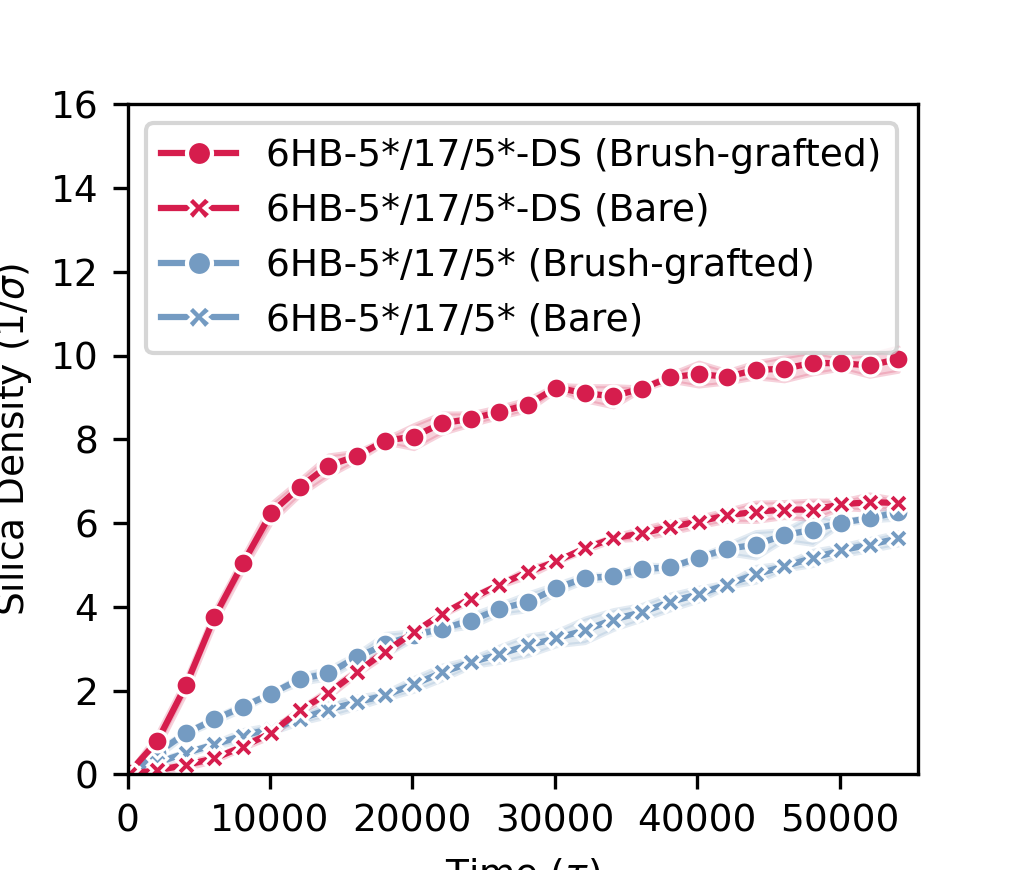

In [6]:
import seaborn as sns
import matplotlib as mpl
from matplotlib.pyplot import figure
plt.clf()
plt.close()

#figure(figsize=(3.7, 2.9), dpi=300)
#mpl.rcParams['pdf.fonttype'] = 42 #To make this editable in Adobe
#mpl.rcParams.update({'font.size': 9})
#mpl.rcParams['lines.markeredgewidth'] = 1
#sns.set_palette("magma")
#palette='bright #,style="Type", #617A55 #A4D0A4 '#C51605',"#FD8D14","#4682A9","#91C8E4"

#Method 1
# two categories
#ax = sns.lineplot(data=df_sliced, x="Timestep", y="Value",
#             hue="Region",style="Type",palette=['#617A55',"#A4D0A4"],errorbar='sd',dashes=False,markersize=5)#markers=['o','v'],markers=['o','v'], markersize=1.7,dashes=False,alpha=1, linewidth=0)#,errorbar='sd',marker='o')

#Method 2
# no categories ['o','o','o','o'] #marker = ['o' #"#f04705","#
color_candidate_1 = ['#6D9738','#6D9738','#D61D4D','#D61D4D']
color_candidate_2 = ['#749BC2','#749BC2','#D61D4D','#D61D4D']
color_candidate_3 = ['#61677A','#61677A','#D61D4D','#D61D4D']
color_candidate = [color_candidate_1,color_candidate_2,color_candidate_3]
for idx,candidate in enumerate(color_candidate[1:2]):
    figure(figsize=(3.4, 2.9), dpi=300)
    mpl.rcParams['pdf.fonttype'] = 42 #To make this editable in Adobe
    mpl.rcParams.update({'font.size': 9})
    mpl.rcParams['lines.markeredgewidth'] = 1
    ax = sns.lineplot(data=df_sliced, x="Timestep", y="Value",
                 hue="Name",style="Name",markers = ['o','X'],palette=candidate,errorbar='sd',dashes=False,markersize=5)
    #Screwing around with Legends
    handles,labels = ax.get_legend_handles_labels()
    handles = [handles[2], handles[3],handles[0], handles[1]]
    labels = ['6HB-5*/17/5*-DS (Brush-grafted)','6HB-5*/17/5*-DS (Bare)','6HB-5*/17/5* (Brush-grafted)','6HB-5*/17/5* (Bare)']#[labels[0], labels[1],labels[2], labels[3]]
    for h in handles:
        h.set_markeredgecolor('white')
        h.set_alpha(1.0)

        #h.set_edgecolor("white")
    plt.legend(handles,labels,title='', loc='upper left')
    ax.set(ylim=(0, 16))
    ax.set(xlim=(0, 55500))

    #specfiy axis labels
    ax.set(xlabel=r'Time ($\tau$)',
           ylabel=r'Silica Density (1/$\sigma$)',
           title='')
    

    plt.savefig("adsorption_combined_{}.pdf".format(idx),bbox_inches='tight',dpi=300)
    plt.show()
    #plt.clf()
    #plt.close()
    #plt.savefig("adsorption_ssDNA_2.pdf",dpi=300)
    #plt.show()

In [2]:
dsMRT_arr = []
ssMRT_arr = []
for i in [111,222,333]:
    MRT_i = np.load("dsDNA_mean_residence_time_{}.npy".format(i))
    dsMRT_arr.append(MRT_i*50000*0.002) #frames convert to tau
    MRT_i = np.load("ssDNA_mean_residence_time_{}.npy".format(i))
    ssMRT_arr.append(MRT_i*50000*0.002)#frames convert to tau
#print(dsMRT_arr)
print("dsDNA: {:.2f} +- {:.2f} standard error".format(np.mean(dsMRT_arr),np.std(dsMRT_arr)))
print("ssDNA: {:.2f} +- {:.2f} standard error".format(np.mean(ssMRT_arr),np.std(ssMRT_arr)))

dsDNA: 646.59 +- 3.82 standard error
ssDNA: 161.45 +- 1.43 standard error


# Response to Reviewer

In [18]:
#for i in range(1,4):
for i in [0.9536,1.14,1.2743,1.4]:
    file = 'silicification_response_reviewer/ssDNA/product_{}.lammpstrj'.format(i)
    data,box_xy = Process_data(file)
    brush,middle = Neighbor_Selection_Distance_based(data,box_xy)

    total_number_of_silica = (np.array(brush)+np.array(middle))/193
    
    df = pd.DataFrame({'Silica Density':total_number_of_silica})
    df.to_csv('revsssurface_density_{}.csv'.format(i), index=False)

    
    file = 'silicification_response_reviewer/hairpin/product_{}.lammpstrj'.format(i)
    data,box_xy = Process_data(file)
    brush,middle = Neighbor_Selection_Distance_based(data,box_xy)
    total_number_of_silica = (np.array(brush)+np.array(middle))/193
    df = pd.DataFrame({'Silica Density':total_number_of_silica})
    df.to_csv('revsurface_density_{}.csv'.format(i), index=False)


In [19]:
import seaborn
Mg_concenc = [7,10,12.5,15,7,10,12.5,15] #ss then ds

#csv_files = ['sssurface_density_1.csv', 'sssurface_density_2.csv', 'sssurface_density_3.csv']
csv_files = ['revsssurface_density_0.9536.csv', 'revsssurface_density_1.14.csv', 'revsssurface_density_1.2743.csv','revsssurface_density_1.4.csv',\
            'revsurface_density_0.9536.csv', 'revsurface_density_1.14.csv', 'revsurface_density_1.2743.csv','revsurface_density_1.4.csv']

# Load and process the data from each CSV file
data_frames = []
for index,file_name in enumerate(csv_files):
    df = pd.read_csv(file_name)
    melted_df = df.melt(var_name='Silica Density', value_name='Value')
    melted_df['Magnesium concentration'] = '{}mM'.format(Mg_concenc[index])#file_name[-5]) #so would be Sample 1 Sample 2
    if file_name[3:5]=='ss':
        melted_df['Type'] = '6HB-5*/17/5*'
    else:
        melted_df['Type'] = '6HB-5*/17/5*-DS'
    #melted_df['Source'] = 'File {}'.format(index) # so that sns will avereage based on this column
    melted_df['Timestep'] = melted_df.groupby('Silica Density').cumcount()*50000*0.002 #Assign time points
    # Apply the custom function to create a new column 'Result'
    #melted_df['Value'] = melted_df.apply(divide_by_length, axis=1)
    data_frames.append(melted_df)
#df1 = pd.read_csv('surface_density_1.csv')
#df2 = pd.read_csv('surface_density_2.csv')
concatenated_df = pd.concat(data_frames, ignore_index=True)
#df_all = df1.merge(df2, left_index=True,right_index=True)
#concatenated_df['timepoint'] = concatenated_df.groupby('Source').cumcount()

In [20]:
#df_sliced = concatenated_df 
timestep_to_plot = list(range(100,55100,2000))
#print(timestep_to_plot)
df_sliced =  concatenated_df[concatenated_df['Timestep'].isin(timestep_to_plot)]
print(df_sliced)
# Merge Region and type according to Dr. Arya's request
df_sliced["Name"] =  df_sliced['Type']#+ ' ' + '(' + df_sliced["Region"] +')'
df_sliced.head()

      Silica Density     Value Magnesium concentration             Type  \
1     Silica Density  0.041451                     7mM     6HB-5*/17/5*   
21    Silica Density  0.321244                     7mM     6HB-5*/17/5*   
41    Silica Density  0.616580                     7mM     6HB-5*/17/5*   
61    Silica Density  0.906736                     7mM     6HB-5*/17/5*   
81    Silica Density  1.170984                     7mM     6HB-5*/17/5*   
...              ...       ...                     ...              ...   
4325  Silica Density  0.067358                    15mM  6HB-5*/17/5*-DS   
4345  Silica Density  0.113990                    15mM  6HB-5*/17/5*-DS   
4365  Silica Density  0.098446                    15mM  6HB-5*/17/5*-DS   
4385  Silica Density  0.098446                    15mM  6HB-5*/17/5*-DS   
4405  Silica Density  0.129534                    15mM  6HB-5*/17/5*-DS   

      Timestep  
1        100.0  
21      2100.0  
41      4100.0  
61      6100.0  
81      8100.0

/tmp/ipykernel_555/3438129976.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sliced["Name"] =  df_sliced['Type']#+ ' ' + '(' + df_sliced["Region"] +')'


,Silica Density,Value,Magnesium concentration,Type,Timestep,Name
1,Silica Density,0.041451,7mM,6HB-5*/17/5*,100.0,6HB-5*/17/5*
21,Silica Density,0.321244,7mM,6HB-5*/17/5*,2100.0,6HB-5*/17/5*
41,Silica Density,0.616580,7mM,6HB-5*/17/5*,4100.0,6HB-5*/17/5*
61,Silica Density,0.906736,7mM,6HB-5*/17/5*,6100.0,6HB-5*/17/5*
81,Silica Density,1.170984,7mM,6HB-5*/17/5*,8100.0,6HB-5*/17/5*


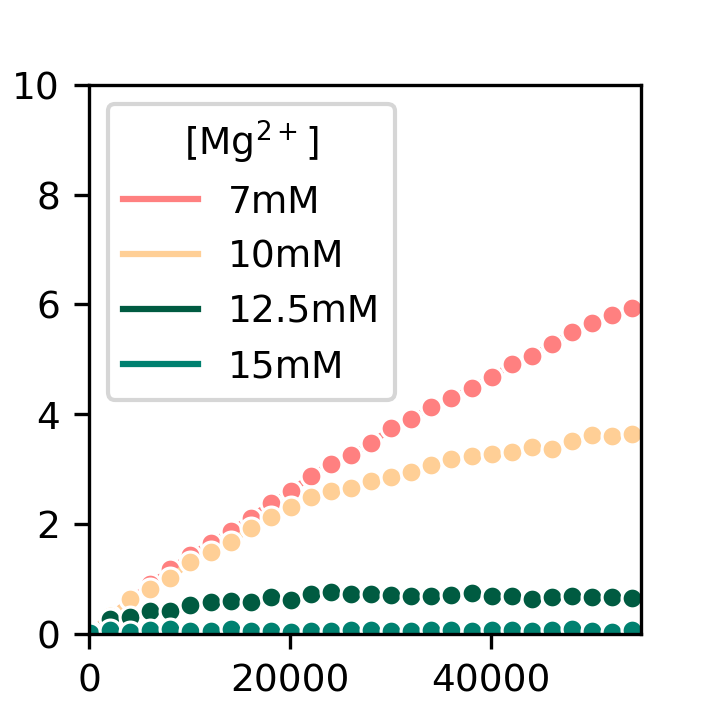

In [40]:
import seaborn as sns
import matplotlib as mpl
from matplotlib.pyplot import figure

color_candidate_1 = ['#6D9738','#6D9738','#D61D4D','#D61D4D']
color_candidate_2 = ['#FF8080','#FFCF96','#005B41','#008170']
color_candidate_3 = ['#61677A','#61677A','#D61D4D','#D61D4D']
color_candidate = [color_candidate_1,color_candidate_2,color_candidate_3]
for idx,candidate in enumerate(color_candidate[1:2]):
    figure(figsize=(2.375, 2.375), dpi=300)
    mpl.rcParams['pdf.fonttype'] = 42 #To make this editable in Adobe
    mpl.rcParams.update({'font.size': 9})
    mpl.rcParams['lines.markeredgewidth'] = 1 #,style="Name"
    ax = sns.lineplot(data=df_sliced.loc[df_sliced['Type'] == '6HB-5*/17/5*'], x="Timestep", y="Value",
                 hue="Magnesium concentration", marker =  'o',errorbar=None,palette=candidate,dashes=False,markersize=5) #errorbar='sd'
    #Screwing around with Legends
    handles,labels = ax.get_legend_handles_labels()
    handles = [handles[0], handles[1],handles[2], handles[3]]
    #labels = ['6HB-5*/17/5*-DS (Brush-grafted)','6HB-5*/17/5*-DS (Bare)','6HB-5*/17/5* (Brush-grafted)','6HB-5*/17/5* (Bare)']#[labels[0], labels[1],labels[2], labels[3]]
    #for h in handles:
    #    h.set_markeredgecolor('white')
    #    h.set_alpha(1.0)

        #h.set_edgecolor("white")
    plt.legend(handles,labels,title=r'[Mg$^{2+}$]', loc='upper left')
    ax.set(ylim=(0, 10))
    ax.set(xlim=(0, 55000))

    #specfiy axis labels
    ax.set(xlabel=r'Time ($\tau$)',
           ylabel=r'Silica Density (1/$\sigma$)',
           title='')
    

    plt.savefig("adsorption_reviewer_{}.pdf".format(idx),bbox_inches='tight',dpi=300)
    plt.show()